In [2]:
# Initialization
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [3]:
n = 1000

# Vector of states
states = np.repeat("S",n)
states[0] = "I"

# Probabilities of entering 
prob_S_E = 0.9
prob_I_R = 0.3

n_S = np.array([len(np.where(states == "S")[0])])
n_E = np.array([len(np.where(states == "E")[0])])
n_I = np.array([len(np.where(states == "I")[0])])
n_R = np.array([len(np.where(states == "R")[0])])

E_times = np.zeros(n)
E_mean = 5
E_scale = 1

while "I" in states:
    
    # Get positions of S, I, R
    S_index = np.where(states == "S")[0]
    E_index = np.where(states == "E")[0]
    I_index = np.where(states == "I")[0]
    R_index = np.where(states == "R")[0]
    
    # Update exposed
    E_times[E_index] = E_times[E_index] - 1
    states[np.where((E_times == 0) & (states == "E"))] = "I"

    # Update susceptible
    prob_S_E_t = prob_S_E * len(I_index)/n
    states[S_index] = np.random.choice(np.array(["S", "E"]),p = np.array([1-prob_S_E_t, prob_S_E_t]), size = len(S_index))
    
    # Assign incubation time for exposed
    E_index_new = np.where((states == "E") & (E_times == 0))
    E_times[E_index_new] = np.round(np.random.normal(loc = E_mean, scale = E_scale))
    
    # Update infected
    states[I_index] = np.random.choice(np.array(["I", "R"]),p = np.array([1-prob_I_R, prob_I_R]), size = len(I_index))


    n_S = np.concatenate([n_S, np.array([len(np.where(states == "S")[0])])])
    n_E = np.concatenate([n_E, np.array([len(np.where(states == "E")[0])])])
    n_I = np.concatenate([n_I, np.array([len(np.where(states == "I")[0])])])
    n_R = np.concatenate([n_R, np.array([len(np.where(states == "R")[0])])])

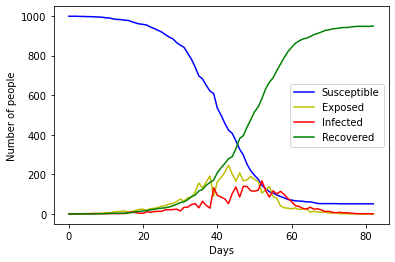

Maximum number of infected:  167


In [4]:
plt.figure()
plt.plot(n_S, "-b", label = "Susceptible")
plt.plot(n_E, "-y", label = "Exposed")
plt.plot(n_I, "-r", label = "Infected")
plt.plot(n_R, "-g", label = "Recovered")
plt.ylabel("Number of people")
plt.xlabel("Days")
#plt.xlim(0,100)
plt.legend()
plt.show()

print("Maximum number of infected: ", max(n_I))